In [2]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

# Load the images directories
#path = "./Desktop/DataFlair/brain_tumor_dataset"


In [3]:
from zipfile import ZipFile
file_name = "/content/brain_tumor_dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
path1="/content/brain_tumor_dataset"
image_paths = list(paths.list_images(path1))

In [5]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

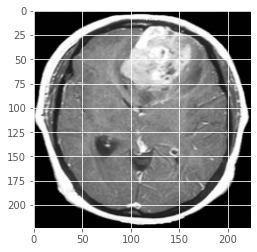

In [25]:
def plot_image(image):
    plt.imshow(image)

plot_image(images[101])

In [24]:
labels[101]

array([0., 1.], dtype=float32)

In [7]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [15]:
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
28/28 [==============================] - 127s 5s/step - loss: 0.7707 - accuracy: 0.5708 - val_loss: 0.6211 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 111s 4s/step - loss: 0.6796 - accuracy: 0.6027 - val_loss: 0.5863 - val_accuracy: 0.6154
Epoch 3/10
28/28 [==============================] - 110s 4s/step - loss: 0.6212 - accuracy: 0.6347 - val_loss: 0.5510 - val_accuracy: 0.6154
Epoch 4/10
28/28 [==============================] - 110s 4s/step - loss: 0.6032 - accuracy: 0.6804 - val_loss: 0.5289 - val_accuracy: 0.9615
Epoch 5/10
28/28 [==============================] - 112s 4s/step - loss: 0.5759 - accuracy: 0.7717 - val_loss: 0.4906 - val_accuracy: 0.8462
Epoch 6/10
28/28 [==============================] - 110s 4s/step - loss: 0.5812 - accuracy: 0.7215 - val_loss: 0.4672 - val_accuracy: 0.9231
Epoch 7/10
28/28 [==============================] - 110s 4s/step - loss: 0.5376 - accuracy: 0.7489 - val_loss: 0.4473 - val_accuracy: 0.9615
Epoch 8/10
28

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

          no       1.00      0.90      0.95        10
         yes       0.94      1.00      0.97        16

    accuracy                           0.96        26
   macro avg       0.97      0.95      0.96        26
weighted avg       0.96      0.96      0.96        26

[[ 9  1]
 [ 0 16]]


In [17]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9615


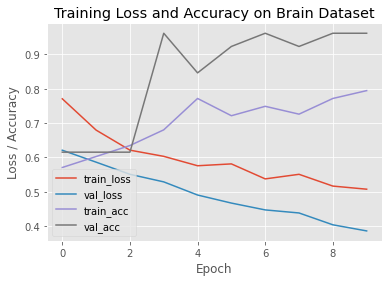

In [26]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")